<a href="https://colab.research.google.com/github/me1nna/fake-image-detection/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet and Transformers for fake images detection

Установка зависимостей

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import random
import os

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision.transforms import v2
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = "42"

In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Apr  3 09:20:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

##Анализ и загрузка данных

In [ ]:
!gdown --id 13rZ1HNOWsN-cTYgYHu0S3UYUHI0KAUBV
!gdown --id 1qjK-uwy20OAWCO1l39RNvjRgjsZiFqm0
!gdown --id 1Heeu9E9vI3MtkYE-_iZdGGcytm5Mw8ha
!gdown --id 1vnG3dlMb9wxo0P-noc84LUBaZNjwumMq
!gdown --id 1BW2ARIM2r0EgL5Z4A8E0O4PXB2BNRhmA

!unzip "images.zip"

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
data = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

Можно заметить, что некоторые файлы в датафрейме не имеют расширения. С помощью простого просмотра файлов становится ясно: если расширение пропущено, то у файла .png

In [ ]:
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        full_path = os.path.join('/content/images', image_path)
        if not os.path.isfile(full_path):
            full_path += ".png"
        try:
            images.append(full_path)
        except Exception as e:
            print(f"Не удалось загрузить изображение: {full_path}")
            print(f"Ошибка: {e}")
            continue
    return images

In [ ]:
# загрузим файлы

train_files = load_images(data["id"])
test_files = load_images(data_test["id"])

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'test'] # тренируем на всем трейне
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class FakeDatasetAdvanced(Dataset):
    """
    Класс датасета с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, labels=None):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        if self.mode != 'test':
            self.labels = labels

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        # некоторые картинки png, соответственно имеют формат RGBA. Будем переводить всех в ргб для упрощения работы с ними =)
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'test':
            transform = v2.Compose([
                v2.Resize(size=(224,224), antialias=True),
                v2.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augmentations = v2.RandomChoice([
                v2.RandomRotation(degrees=(-25, 25)),
                v2.RandomHorizontalFlip(p=1),
                v2.RandomPerspective(distortion_scale=0.3, p=1.0),
                v2.RandomPosterize(bits=4)
            ])
            transform = v2.Compose([
                augmentations,
                v2.Resize(size=(224,224), antialias=True),
                v2.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            return x, label

In [ ]:
train_dataset = FakeDatasetAdvanced(train_files, mode='train', labels=data["target"])
test_dataset = FakeDatasetAdvanced(test_files, mode="test")

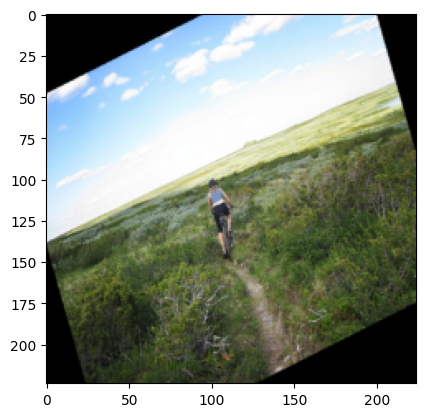

In [ ]:
imshow(train_dataset[5][0])

In [ ]:
from torch.utils.data import WeightedRandomSampler

In [ ]:
df = pd.DataFrame(data["target"], columns=['class']).value_counts().to_frame().reset_index()
counts = pd.Series(data["target"]).value_counts()

In [ ]:
counts

0    667
1    345
Name: target, dtype: int64

In [ ]:
# Словарь весов для каждого из классов
weights = counts.astype(float).apply(lambda x: 1/x).to_dict()

# Список весов для каждого элемента из датасета
sample_weights = [weights[label] for label in train_dataset.labels]

# Общее число элементов в датасете, с учетом весов
N = counts.max().tolist() * len(weights)

In [ ]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def train(model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    train_acc {t_acc:0.4f} "

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.BCEWithLogitsLoss()

        # Observe that all parameters are being optimized
        optimizer = optim.Adam(model.parameters(), lr=0.0005)

        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, exp_lr_scheduler)
            print("loss", train_loss)

            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                            t_acc=train_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

In [ ]:
batch_size = 256

#DataLoader для тренировки, с семплером
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
history_all = []

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torchvision.models as models
import torch.optim as optim
from torchvision.models import ResNet101_Weights
from torch.optim import lr_scheduler
n_classes = 2

model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_ftrs = model.fc.in_features

# изменяем последний слой
model.fc = nn.Linear(num_ftrs, n_classes)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 96.1MB/s]


In [ ]:
history = train(model=model, epochs=10, batch_size=64)

epoch:  10%|█         | 1/10 [00:31<04:45, 31.71s/it]

loss 0.34262429548817663

Epoch 001 train_loss: 0.3426     train_acc 0.8379 



epoch:  20%|██        | 2/10 [01:03<04:13, 31.68s/it]

loss 0.07084558079600806

Epoch 002 train_loss: 0.0708     train_acc 0.9812 



epoch:  30%|███       | 3/10 [01:35<03:42, 31.73s/it]

loss 0.05531089177553951

Epoch 003 train_loss: 0.0553     train_acc 0.9832 



epoch:  40%|████      | 4/10 [02:07<03:12, 32.02s/it]

loss 0.037205467335585315

Epoch 004 train_loss: 0.0372     train_acc 0.9872 



epoch:  50%|█████     | 5/10 [02:39<02:39, 31.98s/it]

loss 0.02593559988962096

Epoch 005 train_loss: 0.0259     train_acc 0.9941 



epoch:  60%|██████    | 6/10 [03:11<02:08, 32.11s/it]

loss 0.023892702063611843

Epoch 006 train_loss: 0.0239     train_acc 0.9901 



epoch:  70%|███████   | 7/10 [03:44<01:36, 32.32s/it]

loss 0.05327716739222466

Epoch 007 train_loss: 0.0533     train_acc 0.9842 



epoch:  80%|████████  | 8/10 [04:16<01:04, 32.11s/it]

loss 0.034879419978398815

Epoch 008 train_loss: 0.0349     train_acc 0.9931 



epoch:  90%|█████████ | 9/10 [04:51<00:33, 33.10s/it]

loss 0.014582879041605021

Epoch 009 train_loss: 0.0146     train_acc 0.9951 



epoch: 100%|██████████| 10/10 [05:25<00:00, 32.57s/it]

loss 0.007351173218634171

Epoch 010 train_loss: 0.0074     train_acc 0.9970 


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
my_submit = pd.read_csv("sample_submission.csv")

In [ ]:
my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})

Сабмит при 10 эпохах

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,0.008543
1,j4Rhioq7R3.jpeg,0.000146
2,rD0hgFHJUZ.jpeg,0.000865
3,aY5z1EJsJ6.jpeg,0.999996
4,qZ3IoxD2TE.jpeg,0.008915


In [ ]:
my_submit.to_csv("sbm1.csv", index=False)

In [ ]:
history = train(model=model, epochs=20, batch_size=64)

epoch:   5%|▌         | 1/20 [00:36<11:35, 36.58s/it]

loss 0.02639703858982433

Epoch 001 train_loss: 0.0264     train_acc 0.9891 



epoch:  10%|█         | 2/20 [01:09<10:21, 34.53s/it]

loss 0.046944018114696846

Epoch 002 train_loss: 0.0469     train_acc 0.9842 



epoch:  15%|█▌        | 3/20 [01:42<09:30, 33.57s/it]

loss 0.043988603200365906

Epoch 003 train_loss: 0.0440     train_acc 0.9852 



epoch:  20%|██        | 4/20 [02:16<08:59, 33.71s/it]

loss 0.030890274395349

Epoch 004 train_loss: 0.0309     train_acc 0.9921 



epoch:  25%|██▌       | 5/20 [02:48<08:18, 33.20s/it]

loss 0.03342326262251662

Epoch 005 train_loss: 0.0334     train_acc 0.9872 



epoch:  30%|███       | 6/20 [03:20<07:38, 32.74s/it]

loss 0.024938627300791355

Epoch 006 train_loss: 0.0249     train_acc 0.9901 



epoch:  35%|███▌      | 7/20 [03:52<07:04, 32.63s/it]

loss 0.052475054185145455

Epoch 007 train_loss: 0.0525     train_acc 0.9822 



epoch:  40%|████      | 8/20 [04:25<06:31, 32.64s/it]

loss 0.02741967419184479

Epoch 008 train_loss: 0.0274     train_acc 0.9941 



epoch:  45%|████▌     | 9/20 [04:58<05:59, 32.69s/it]

loss 0.012073964771369228

Epoch 009 train_loss: 0.0121     train_acc 0.9970 



epoch:  50%|█████     | 10/20 [05:30<05:24, 32.46s/it]

loss 0.012989128903916526

Epoch 010 train_loss: 0.0130     train_acc 0.9941 



epoch:  55%|█████▌    | 11/20 [06:02<04:53, 32.56s/it]

loss 0.0075595614403944555

Epoch 011 train_loss: 0.0076     train_acc 0.9980 



epoch:  60%|██████    | 12/20 [06:35<04:20, 32.58s/it]

loss 0.0024407800239153767

Epoch 012 train_loss: 0.0024     train_acc 0.9990 



epoch:  65%|██████▌   | 13/20 [07:07<03:45, 32.28s/it]

loss 0.0061923555036815315

Epoch 013 train_loss: 0.0062     train_acc 0.9980 



epoch:  70%|███████   | 14/20 [07:39<03:14, 32.36s/it]

loss 0.004089102498859604

Epoch 014 train_loss: 0.0041     train_acc 0.9980 



epoch:  75%|███████▌  | 15/20 [08:11<02:40, 32.16s/it]

loss 0.00028098870394107234

Epoch 015 train_loss: 0.0003     train_acc 1.0000 



epoch:  80%|████████  | 16/20 [08:43<02:08, 32.25s/it]

loss 0.0006494035029757617

Epoch 016 train_loss: 0.0006     train_acc 1.0000 



epoch:  85%|████████▌ | 17/20 [09:16<01:36, 32.32s/it]

loss 0.0033823733597830733

Epoch 017 train_loss: 0.0034     train_acc 0.9990 



epoch:  90%|█████████ | 18/20 [09:48<01:04, 32.33s/it]

loss 0.00034423464869623893

Epoch 018 train_loss: 0.0003     train_acc 1.0000 



epoch:  95%|█████████▌| 19/20 [10:21<00:32, 32.39s/it]

loss 0.001666583477316071

Epoch 019 train_loss: 0.0017     train_acc 0.9990 



epoch: 100%|██████████| 20/20 [10:52<00:00, 32.65s/it]

loss 0.00018747465545760207

Epoch 020 train_loss: 0.0002     train_acc 1.0000 


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})

Сабмит при 20 эпохах

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,2.876634e-05
1,j4Rhioq7R3.jpeg,7.576230e-03
2,rD0hgFHJUZ.jpeg,3.262470e-07
3,aY5z1EJsJ6.jpeg,1.000000e+00
4,qZ3IoxD2TE.jpeg,3.835750e-06


In [ ]:
my_submit.to_csv("sbm2.csv", index=False)

In [ ]:
def train(model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    train_acc {t_acc:0.4f} "

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.BCEWithLogitsLoss()

        optimizer = optim.Adam(model.parameters(), lr=0.0005)

        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, exp_lr_scheduler)
            print("loss", train_loss)

            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           t_acc=train_acc))

    return history

In [ ]:
!pip install timm
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Загрузка предварительно обученной модели Vision Transformer
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Получение конфигурации данных для модели и создание соответствующих трансформаций
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

# Изменение последнего классификационного слоя для вашего числа классов (например, для бинарной классификации)
model.head = nn.Linear(model.head.in_features, 2)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
model = model.to(DEVICE)

In [ ]:
history = train(model=model, epochs=20, batch_size=32)

epoch:   5%|▌         | 1/20 [00:45<14:26, 45.61s/it]

loss 1.2154332568994153

Epoch 001 train_loss: 1.2154     train_acc 0.5474 



epoch:  10%|█         | 2/20 [01:32<13:53, 46.31s/it]

loss 0.7107987156498573

Epoch 002 train_loss: 0.7108     train_acc 0.6057 



epoch:  15%|█▌        | 3/20 [02:20<13:21, 47.15s/it]

loss 0.6655926381646409

Epoch 003 train_loss: 0.6656     train_acc 0.6383 



epoch:  20%|██        | 4/20 [03:08<12:38, 47.38s/it]

loss 0.6471306285839307

Epoch 004 train_loss: 0.6471     train_acc 0.6403 



epoch:  25%|██▌       | 5/20 [03:57<11:58, 47.91s/it]

loss 0.6620652119632766

Epoch 005 train_loss: 0.6621     train_acc 0.6225 



epoch:  30%|███       | 6/20 [04:45<11:11, 47.96s/it]

loss 0.629934025611802

Epoch 006 train_loss: 0.6299     train_acc 0.6443 



epoch:  35%|███▌      | 7/20 [05:34<10:28, 48.37s/it]

loss 0.6169702638043717

Epoch 007 train_loss: 0.6170     train_acc 0.6621 



epoch:  40%|████      | 8/20 [06:22<09:40, 48.38s/it]

loss 0.5110885312434713

Epoch 008 train_loss: 0.5111     train_acc 0.7648 



epoch:  45%|████▌     | 9/20 [07:11<08:51, 48.33s/it]

loss 0.515468535333754

Epoch 009 train_loss: 0.5155     train_acc 0.7609 



epoch:  50%|█████     | 10/20 [07:59<08:04, 48.42s/it]

loss 0.4406727326246118

Epoch 010 train_loss: 0.4407     train_acc 0.7984 



epoch:  55%|█████▌    | 11/20 [08:47<07:15, 48.38s/it]

loss 0.4171905371511407

Epoch 011 train_loss: 0.4172     train_acc 0.8053 



epoch:  60%|██████    | 12/20 [09:36<06:27, 48.42s/it]

loss 0.37731065639394074

Epoch 012 train_loss: 0.3773     train_acc 0.8419 



epoch:  65%|██████▌   | 13/20 [10:24<05:39, 48.46s/it]

loss 0.4552432496557123

Epoch 013 train_loss: 0.4552     train_acc 0.7905 



epoch:  70%|███████   | 14/20 [11:14<04:52, 48.71s/it]

loss 0.3385520851894801

Epoch 014 train_loss: 0.3386     train_acc 0.8547 



epoch:  75%|███████▌  | 15/20 [12:03<04:04, 48.90s/it]

loss 0.2525767822981823

Epoch 015 train_loss: 0.2526     train_acc 0.8933 



epoch:  80%|████████  | 16/20 [12:52<03:15, 48.80s/it]

loss 0.20076208505705884

Epoch 016 train_loss: 0.2008     train_acc 0.9209 



epoch:  85%|████████▌ | 17/20 [13:41<02:26, 48.89s/it]

loss 0.2368616148417175

Epoch 017 train_loss: 0.2369     train_acc 0.8913 



epoch:  90%|█████████ | 18/20 [14:30<01:38, 49.03s/it]

loss 0.21332202398258707

Epoch 018 train_loss: 0.2133     train_acc 0.9101 



epoch:  95%|█████████▌| 19/20 [15:19<00:48, 48.97s/it]

loss 0.1774290808045817

Epoch 019 train_loss: 0.1774     train_acc 0.9308 



epoch: 100%|██████████| 20/20 [16:10<00:00, 48.51s/it]

loss 0.20058269757527136

Epoch 020 train_loss: 0.2006     train_acc 0.9190 


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,0.229123
1,j4Rhioq7R3.jpeg,0.115546
2,rD0hgFHJUZ.jpeg,0.019476
3,aY5z1EJsJ6.jpeg,0.966672
4,qZ3IoxD2TE.jpeg,0.104707


In [ ]:
my_submit.to_csv("sbm3.csv", index=False)

In [ ]:
# Загрузка предварительно обученной модели Vision Transformer
model = timm.create_model('vit_small_patch16_224', pretrained=True)

# Получение конфигурации данных для модели и создание соответствующих трансформаций
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

# Изменение последнего классификационного слоя для вашего числа классов (например, для бинарной классификации)
model.head = nn.Linear(model.head.in_features, 2)

model.to(DEVICE)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
history = train(model=model, epochs=30, batch_size=64)

epoch:   3%|▎         | 1/30 [00:26<12:50, 26.58s/it]

loss 1.3780219880017368

Epoch 001 train_loss: 1.3780     train_acc 0.5988 



epoch:   7%|▋         | 2/30 [00:52<12:14, 26.24s/it]

loss 0.6654436760269135

Epoch 002 train_loss: 0.6654     train_acc 0.6225 



epoch:  10%|█         | 3/30 [01:17<11:28, 25.49s/it]

loss 0.6458899861739087

Epoch 003 train_loss: 0.6459     train_acc 0.6522 



epoch:  13%|█▎        | 4/30 [01:44<11:18, 26.10s/it]

loss 0.5909826180680468

Epoch 004 train_loss: 0.5910     train_acc 0.6818 



epoch:  17%|█▋        | 5/30 [02:13<11:22, 27.32s/it]

loss 0.5323905470107384

Epoch 005 train_loss: 0.5324     train_acc 0.7332 



epoch:  20%|██        | 6/30 [02:41<11:02, 27.59s/it]

loss 0.3917248545899222

Epoch 006 train_loss: 0.3917     train_acc 0.8409 



epoch:  23%|██▎       | 7/30 [03:06<10:11, 26.58s/it]

loss 0.33959119510744873

Epoch 007 train_loss: 0.3396     train_acc 0.8567 



epoch:  27%|██▋       | 8/30 [03:30<09:28, 25.84s/it]

loss 0.21830288105802573

Epoch 008 train_loss: 0.2183     train_acc 0.9180 



epoch:  30%|███       | 9/30 [03:54<08:51, 25.32s/it]

loss 0.14945533730295807

Epoch 009 train_loss: 0.1495     train_acc 0.9486 



epoch:  33%|███▎      | 10/30 [04:19<08:25, 25.26s/it]

loss 0.16470774978752664

Epoch 010 train_loss: 0.1647     train_acc 0.9427 



epoch:  37%|███▋      | 11/30 [04:44<07:58, 25.18s/it]

loss 0.13702850517901508

Epoch 011 train_loss: 0.1370     train_acc 0.9437 



epoch:  40%|████      | 12/30 [05:10<07:34, 25.24s/it]

loss 0.10913530740106529

Epoch 012 train_loss: 0.1091     train_acc 0.9644 



epoch:  43%|████▎     | 13/30 [05:35<07:06, 25.09s/it]

loss 0.16372119526382492

Epoch 013 train_loss: 0.1637     train_acc 0.9407 



epoch:  47%|████▋     | 14/30 [06:00<06:42, 25.14s/it]

loss 0.15946281253702554

Epoch 014 train_loss: 0.1595     train_acc 0.9407 



epoch:  50%|█████     | 15/30 [06:24<06:14, 24.98s/it]

loss 0.09259723247628909

Epoch 015 train_loss: 0.0926     train_acc 0.9654 



epoch:  53%|█████▎    | 16/30 [06:49<05:48, 24.92s/it]

loss 0.056108544230932304

Epoch 016 train_loss: 0.0561     train_acc 0.9783 



epoch:  57%|█████▋    | 17/30 [07:14<05:25, 25.00s/it]

loss 0.05603934848025854

Epoch 017 train_loss: 0.0560     train_acc 0.9802 



epoch:  60%|██████    | 18/30 [07:39<05:00, 25.01s/it]

loss 0.03818071012204815

Epoch 018 train_loss: 0.0382     train_acc 0.9842 



epoch:  63%|██████▎   | 19/30 [08:04<04:34, 24.95s/it]

loss 0.056019162788633774

Epoch 019 train_loss: 0.0560     train_acc 0.9783 



epoch:  67%|██████▋   | 20/30 [08:29<04:10, 25.01s/it]

loss 0.031412396167695755

Epoch 020 train_loss: 0.0314     train_acc 0.9911 



epoch:  70%|███████   | 21/30 [08:55<03:46, 25.11s/it]

loss 0.046190097353792946

Epoch 021 train_loss: 0.0462     train_acc 0.9812 



epoch:  73%|███████▎  | 22/30 [09:20<03:21, 25.20s/it]

loss 0.03535807577583924

Epoch 022 train_loss: 0.0354     train_acc 0.9862 



epoch:  77%|███████▋  | 23/30 [09:45<02:55, 25.09s/it]

loss 0.023457005148819782

Epoch 023 train_loss: 0.0235     train_acc 0.9901 



epoch:  80%|████████  | 24/30 [10:10<02:30, 25.06s/it]

loss 0.02276862000406024

Epoch 024 train_loss: 0.0228     train_acc 0.9911 



epoch:  83%|████████▎ | 25/30 [10:35<02:05, 25.09s/it]

loss 0.027197278805975268

Epoch 025 train_loss: 0.0272     train_acc 0.9921 



epoch:  87%|████████▋ | 26/30 [11:00<01:40, 25.11s/it]

loss 0.012731765979429772

Epoch 026 train_loss: 0.0127     train_acc 0.9960 



epoch:  90%|█████████ | 27/30 [11:26<01:15, 25.18s/it]

loss 0.015851796394869274

Epoch 027 train_loss: 0.0159     train_acc 0.9931 



epoch:  93%|█████████▎| 28/30 [11:51<00:50, 25.14s/it]

loss 0.012801400183335594

Epoch 028 train_loss: 0.0128     train_acc 0.9951 



epoch:  97%|█████████▋| 29/30 [12:16<00:25, 25.17s/it]

loss 0.013512037846300265

Epoch 029 train_loss: 0.0135     train_acc 0.9941 



epoch: 100%|██████████| 30/30 [12:41<00:00, 25.38s/it]

loss 0.008266715951293354

Epoch 030 train_loss: 0.0083     train_acc 0.9970 


In [ ]:
history = train(model=model, epochs=50, batch_size=32)

epoch:   2%|▏         | 1/50 [00:25<20:30, 25.12s/it]

loss 0.6278346190357897

Epoch 001 train_loss: 0.6278     train_acc 0.7342 



epoch:   4%|▍         | 2/50 [00:49<19:54, 24.88s/it]

loss 0.2960043683824803

Epoch 002 train_loss: 0.2960     train_acc 0.8755 



epoch:   6%|▌         | 3/50 [01:14<19:27, 24.85s/it]

loss 0.2170293756388864

Epoch 003 train_loss: 0.2170     train_acc 0.9180 



epoch:   8%|▊         | 4/50 [01:39<19:02, 24.83s/it]

loss 0.14460422051518332

Epoch 004 train_loss: 0.1446     train_acc 0.9457 



epoch:  10%|█         | 5/50 [02:03<18:30, 24.69s/it]

loss 0.20847473832458374

Epoch 005 train_loss: 0.2085     train_acc 0.9071 



epoch:  12%|█▏        | 6/50 [02:28<18:09, 24.76s/it]

loss 0.10292235432052801

Epoch 006 train_loss: 0.1029     train_acc 0.9565 



epoch:  14%|█▍        | 7/50 [02:53<17:46, 24.80s/it]

loss 0.1979321837425232

Epoch 007 train_loss: 0.1979     train_acc 0.9061 



epoch:  16%|█▌        | 8/50 [03:18<17:20, 24.77s/it]

loss 0.10276231714505923

Epoch 008 train_loss: 0.1028     train_acc 0.9634 



epoch:  18%|█▊        | 9/50 [03:43<16:55, 24.77s/it]

loss 0.05383872594905229

Epoch 009 train_loss: 0.0538     train_acc 0.9812 



epoch:  20%|██        | 10/50 [04:07<16:29, 24.75s/it]

loss 0.05874340870811534

Epoch 010 train_loss: 0.0587     train_acc 0.9802 



epoch:  22%|██▏       | 11/50 [04:32<16:03, 24.71s/it]

loss 0.03904883314582994

Epoch 011 train_loss: 0.0390     train_acc 0.9891 



epoch:  24%|██▍       | 12/50 [04:57<15:39, 24.73s/it]

loss 0.10730740292505785

Epoch 012 train_loss: 0.1073     train_acc 0.9555 



epoch:  26%|██▌       | 13/50 [05:21<15:13, 24.68s/it]

loss 0.060599416140982285

Epoch 013 train_loss: 0.0606     train_acc 0.9802 



epoch:  28%|██▊       | 14/50 [05:46<14:48, 24.68s/it]

loss 0.04753957852986255

Epoch 014 train_loss: 0.0475     train_acc 0.9802 



epoch:  30%|███       | 15/50 [06:10<14:17, 24.51s/it]

loss 0.03278331814348521

Epoch 015 train_loss: 0.0328     train_acc 0.9891 



epoch:  32%|███▏      | 16/50 [06:35<13:54, 24.55s/it]

loss 0.032921989063691835

Epoch 016 train_loss: 0.0329     train_acc 0.9891 



epoch:  34%|███▍      | 17/50 [06:59<13:31, 24.60s/it]

loss 0.02795144098004687

Epoch 017 train_loss: 0.0280     train_acc 0.9921 



epoch:  36%|███▌      | 18/50 [07:25<13:12, 24.76s/it]

loss 0.020000372511765407

Epoch 018 train_loss: 0.0200     train_acc 0.9941 



epoch:  38%|███▊      | 19/50 [07:49<12:42, 24.61s/it]

loss 0.021272804018886753

Epoch 019 train_loss: 0.0213     train_acc 0.9911 



epoch:  40%|████      | 20/50 [08:14<12:23, 24.77s/it]

loss 0.031300037136676874

Epoch 020 train_loss: 0.0313     train_acc 0.9872 



epoch:  42%|████▏     | 21/50 [08:39<11:59, 24.82s/it]

loss 0.01663982781389242

Epoch 021 train_loss: 0.0166     train_acc 0.9931 



epoch:  44%|████▍     | 22/50 [09:03<11:32, 24.73s/it]

loss 0.02144857094367311

Epoch 022 train_loss: 0.0214     train_acc 0.9931 



epoch:  46%|████▌     | 23/50 [09:28<11:07, 24.73s/it]

loss 0.012685626681264594

Epoch 023 train_loss: 0.0127     train_acc 0.9960 



epoch:  48%|████▊     | 24/50 [09:53<10:44, 24.78s/it]

loss 0.014700390913858715

Epoch 024 train_loss: 0.0147     train_acc 0.9951 



epoch:  50%|█████     | 25/50 [10:18<10:22, 24.90s/it]

loss 0.00922537126197395

Epoch 025 train_loss: 0.0092     train_acc 0.9980 



epoch:  52%|█████▏    | 26/50 [10:43<09:58, 24.93s/it]

loss 0.0029736968022384663

Epoch 026 train_loss: 0.0030     train_acc 0.9990 



epoch:  54%|█████▍    | 27/50 [11:08<09:33, 24.95s/it]

loss 0.0023291992166690647

Epoch 027 train_loss: 0.0023     train_acc 1.0000 



epoch:  56%|█████▌    | 28/50 [11:33<09:06, 24.82s/it]

loss 0.013613717757504095

Epoch 028 train_loss: 0.0136     train_acc 0.9970 



epoch:  58%|█████▊    | 29/50 [11:58<08:41, 24.82s/it]

loss 0.008454825304422837

Epoch 029 train_loss: 0.0085     train_acc 0.9960 



epoch:  60%|██████    | 30/50 [12:22<08:16, 24.84s/it]

loss 0.004579695218413877

Epoch 030 train_loss: 0.0046     train_acc 0.9990 



epoch:  62%|██████▏   | 31/50 [12:47<07:52, 24.87s/it]

loss 0.006312151050094788

Epoch 031 train_loss: 0.0063     train_acc 0.9980 



epoch:  64%|██████▍   | 32/50 [13:12<07:25, 24.77s/it]

loss 0.005690587624233849

Epoch 032 train_loss: 0.0057     train_acc 0.9980 



epoch:  66%|██████▌   | 33/50 [13:36<06:58, 24.65s/it]

loss 0.0019184765478065435

Epoch 033 train_loss: 0.0019     train_acc 1.0000 



epoch:  68%|██████▊   | 34/50 [14:01<06:36, 24.79s/it]

loss 0.004878795422749822

Epoch 034 train_loss: 0.0049     train_acc 0.9980 



epoch:  70%|███████   | 35/50 [14:26<06:12, 24.83s/it]

loss 0.0028299886565112506

Epoch 035 train_loss: 0.0028     train_acc 0.9990 



epoch:  72%|███████▏  | 36/50 [14:51<05:47, 24.80s/it]

loss 0.00741895028629723

Epoch 036 train_loss: 0.0074     train_acc 0.9970 



epoch:  74%|███████▍  | 37/50 [15:16<05:22, 24.84s/it]

loss 0.004302575498948737

Epoch 037 train_loss: 0.0043     train_acc 0.9980 



epoch:  76%|███████▌  | 38/50 [15:41<04:58, 24.86s/it]

loss 0.002696907283822691

Epoch 038 train_loss: 0.0027     train_acc 0.9990 



epoch:  78%|███████▊  | 39/50 [16:06<04:33, 24.83s/it]

loss 0.0017081694577535543

Epoch 039 train_loss: 0.0017     train_acc 0.9990 



epoch:  80%|████████  | 40/50 [16:31<04:08, 24.88s/it]

loss 0.013570053231966955

Epoch 040 train_loss: 0.0136     train_acc 0.9941 



epoch:  82%|████████▏ | 41/50 [16:56<03:43, 24.86s/it]

loss 0.007042821340881547

Epoch 041 train_loss: 0.0070     train_acc 0.9970 



epoch:  84%|████████▍ | 42/50 [17:20<03:18, 24.80s/it]

loss 0.004060885933112917

Epoch 042 train_loss: 0.0041     train_acc 0.9990 



epoch:  86%|████████▌ | 43/50 [17:45<02:54, 24.91s/it]

loss 0.0029731924124667144

Epoch 043 train_loss: 0.0030     train_acc 0.9990 



epoch:  88%|████████▊ | 44/50 [18:10<02:28, 24.83s/it]

loss 0.002130364705117101

Epoch 044 train_loss: 0.0021     train_acc 0.9990 



epoch:  90%|█████████ | 45/50 [18:35<02:04, 24.93s/it]

loss 0.005786587858547639

Epoch 045 train_loss: 0.0058     train_acc 0.9980 



epoch:  92%|█████████▏| 46/50 [19:00<01:39, 24.84s/it]

loss 0.0011737993457356906

Epoch 046 train_loss: 0.0012     train_acc 1.0000 



epoch:  94%|█████████▍| 47/50 [19:25<01:14, 24.90s/it]

loss 0.0016770214292322232

Epoch 047 train_loss: 0.0017     train_acc 0.9990 



epoch:  96%|█████████▌| 48/50 [19:50<00:49, 24.88s/it]

loss 0.0019248008028061529

Epoch 048 train_loss: 0.0019     train_acc 0.9990 



epoch:  98%|█████████▊| 49/50 [20:15<00:24, 24.88s/it]

loss 0.0011223855787968003

Epoch 049 train_loss: 0.0011     train_acc 1.0000 



epoch: 100%|██████████| 50/50 [20:39<00:00, 24.80s/it]

loss 0.0006487870005182803

Epoch 050 train_loss: 0.0006     train_acc 1.0000 


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(model, test_loader)

my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})
my_submit.head()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


,id,target
0,Qt1fGUB0Vz.jpeg,0.000003
1,j4Rhioq7R3.jpeg,0.007442
2,rD0hgFHJUZ.jpeg,0.000002
3,aY5z1EJsJ6.jpeg,1.000000
4,qZ3IoxD2TE.jpeg,0.000043


In [ ]:
my_submit.to_csv("subm_t.csv", index=False)

In [ ]:
import torchvision.models as models
import torch.optim as optim
from torchvision.models import ResNet152_Weights
from torch.optim import lr_scheduler
n_classes = 2

model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

num_ftrs = model.fc.in_features

# изменяем последний слой
model.fc = nn.Linear(num_ftrs, n_classes)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:05<00:00, 48.0MB/s]


In [ ]:
history = train(model=model, epochs=40, batch_size=32)

epoch:   2%|▎         | 1/40 [00:41<26:51, 41.31s/it]

loss 0.32654516295835434

Epoch 001 train_loss: 0.3265     train_acc 0.8449 



epoch:   5%|▌         | 2/40 [01:20<25:17, 39.94s/it]

loss 0.09217190306648436

Epoch 002 train_loss: 0.0922     train_acc 0.9704 



epoch:   8%|▊         | 3/40 [01:59<24:26, 39.63s/it]

loss 0.07547327914374619

Epoch 003 train_loss: 0.0755     train_acc 0.9723 



epoch:  10%|█         | 4/40 [02:38<23:42, 39.51s/it]

loss 0.058576116356317674

Epoch 004 train_loss: 0.0586     train_acc 0.9812 



epoch:  12%|█▎        | 5/40 [03:18<23:03, 39.52s/it]

loss 0.0939785208214413

Epoch 005 train_loss: 0.0940     train_acc 0.9674 



epoch:  15%|█▌        | 6/40 [03:58<22:26, 39.59s/it]

loss 0.053527593112039

Epoch 006 train_loss: 0.0535     train_acc 0.9792 



epoch:  18%|█▊        | 7/40 [04:37<21:40, 39.41s/it]

loss 0.062351242970424915

Epoch 007 train_loss: 0.0624     train_acc 0.9783 



epoch:  20%|██        | 8/40 [05:16<21:02, 39.45s/it]

loss 0.02338405077533406

Epoch 008 train_loss: 0.0234     train_acc 0.9931 



epoch:  22%|██▎       | 9/40 [05:56<20:22, 39.44s/it]

loss 0.013685193010366598

Epoch 009 train_loss: 0.0137     train_acc 0.9951 



epoch:  25%|██▌       | 10/40 [06:35<19:40, 39.36s/it]

loss 0.00988294334949653

Epoch 010 train_loss: 0.0099     train_acc 0.9970 



epoch:  28%|██▊       | 11/40 [07:14<18:59, 39.30s/it]

loss 0.013775479538079071

Epoch 011 train_loss: 0.0138     train_acc 0.9970 



epoch:  30%|███       | 12/40 [07:53<18:19, 39.28s/it]

loss 0.0077994795952230625

Epoch 012 train_loss: 0.0078     train_acc 0.9960 



epoch:  32%|███▎      | 13/40 [08:32<17:39, 39.24s/it]

loss 0.012391480614694403

Epoch 013 train_loss: 0.0124     train_acc 0.9960 



epoch:  35%|███▌      | 14/40 [09:11<16:57, 39.12s/it]

loss 0.029421571031095013

Epoch 014 train_loss: 0.0294     train_acc 0.9881 



epoch:  38%|███▊      | 15/40 [09:50<16:18, 39.14s/it]

loss 0.00591239556159434

Epoch 015 train_loss: 0.0059     train_acc 0.9990 



epoch:  40%|████      | 16/40 [10:29<15:38, 39.09s/it]

loss 0.005673210460070535

Epoch 016 train_loss: 0.0057     train_acc 0.9980 



epoch:  42%|████▎     | 17/40 [11:08<14:57, 39.00s/it]

loss 0.0033783354744013295

Epoch 017 train_loss: 0.0034     train_acc 0.9990 



epoch:  45%|████▌     | 18/40 [11:48<14:22, 39.21s/it]

loss 0.004355223889677995

Epoch 018 train_loss: 0.0044     train_acc 0.9980 



epoch:  48%|████▊     | 19/40 [12:27<13:43, 39.19s/it]

loss 0.0024162641563774878

Epoch 019 train_loss: 0.0024     train_acc 0.9990 



epoch:  50%|█████     | 20/40 [13:06<13:05, 39.27s/it]

loss 0.005875054411539484

Epoch 020 train_loss: 0.0059     train_acc 0.9980 



epoch:  52%|█████▎    | 21/40 [13:45<12:24, 39.16s/it]

loss 0.00587579636129858

Epoch 021 train_loss: 0.0059     train_acc 0.9990 



epoch:  55%|█████▌    | 22/40 [14:25<11:46, 39.24s/it]

loss 0.003969161522072251

Epoch 022 train_loss: 0.0040     train_acc 0.9980 



epoch:  57%|█████▊    | 23/40 [15:04<11:08, 39.32s/it]

loss 0.0005203893652858521

Epoch 023 train_loss: 0.0005     train_acc 1.0000 



epoch:  60%|██████    | 24/40 [15:44<10:31, 39.49s/it]

loss 0.0007388322980404489

Epoch 024 train_loss: 0.0007     train_acc 1.0000 



epoch:  62%|██████▎   | 25/40 [16:24<09:53, 39.57s/it]

loss 0.0003251808801701103

Epoch 025 train_loss: 0.0003     train_acc 1.0000 



epoch:  65%|██████▌   | 26/40 [17:03<09:13, 39.57s/it]

loss 0.0006793060084839863

Epoch 026 train_loss: 0.0007     train_acc 1.0000 



epoch:  68%|██████▊   | 27/40 [17:43<08:33, 39.53s/it]

loss 0.001022150240315809

Epoch 027 train_loss: 0.0010     train_acc 1.0000 



epoch:  70%|███████   | 28/40 [18:22<07:53, 39.46s/it]

loss 0.0005977625528448482

Epoch 028 train_loss: 0.0006     train_acc 1.0000 



epoch:  72%|███████▎  | 29/40 [19:02<07:14, 39.51s/it]

loss 0.0029258149334701975

Epoch 029 train_loss: 0.0029     train_acc 0.9990 



epoch:  75%|███████▌  | 30/40 [19:41<06:34, 39.41s/it]

loss 0.00038592623271325994

Epoch 030 train_loss: 0.0004     train_acc 1.0000 



epoch:  78%|███████▊  | 31/40 [20:20<05:53, 39.26s/it]

loss 0.0014070631914220846

Epoch 031 train_loss: 0.0014     train_acc 0.9990 



epoch:  80%|████████  | 32/40 [20:59<05:13, 39.13s/it]

loss 0.00041589145707677437

Epoch 032 train_loss: 0.0004     train_acc 1.0000 



epoch:  82%|████████▎ | 33/40 [21:39<04:36, 39.45s/it]

loss 0.0010133044776486477

Epoch 033 train_loss: 0.0010     train_acc 1.0000 



epoch:  85%|████████▌ | 34/40 [22:19<03:57, 39.56s/it]

loss 0.00041940879011034355

Epoch 034 train_loss: 0.0004     train_acc 1.0000 



epoch:  88%|████████▊ | 35/40 [22:59<03:18, 39.65s/it]

loss 0.0006770373453942782

Epoch 035 train_loss: 0.0007     train_acc 1.0000 



epoch:  90%|█████████ | 36/40 [23:38<02:38, 39.55s/it]

loss 0.00018876562391503498

Epoch 036 train_loss: 0.0002     train_acc 1.0000 



epoch:  92%|█████████▎| 37/40 [24:18<01:58, 39.65s/it]

loss 0.00019917202033373994

Epoch 037 train_loss: 0.0002     train_acc 1.0000 



epoch:  95%|█████████▌| 38/40 [24:57<01:18, 39.46s/it]

loss 0.0003511475917886438

Epoch 038 train_loss: 0.0004     train_acc 1.0000 



epoch:  98%|█████████▊| 39/40 [25:36<00:39, 39.39s/it]

loss 0.00038218930404607516

Epoch 039 train_loss: 0.0004     train_acc 1.0000 



epoch: 100%|██████████| 40/40 [26:16<00:00, 39.42s/it]

loss 0.00029633747070202725

Epoch 040 train_loss: 0.0003     train_acc 1.0000 


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(model, test_loader)

my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})
my_submit.head()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


,id,target
0,Qt1fGUB0Vz.jpeg,1.121590e-05
1,j4Rhioq7R3.jpeg,4.718029e-03
2,rD0hgFHJUZ.jpeg,1.123627e-05
3,aY5z1EJsJ6.jpeg,1.000000e+00
4,qZ3IoxD2TE.jpeg,5.361761e-07


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(model, test_loader)

my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})
my_submit.head()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


,id,target
0,Qt1fGUB0Vz.jpeg,0.726553
1,j4Rhioq7R3.jpeg,0.312550
2,rD0hgFHJUZ.jpeg,0.965204
3,aY5z1EJsJ6.jpeg,0.659606
4,qZ3IoxD2TE.jpeg,0.144980


In [ ]:
my_submit.to_csv("subm5.csv", index=False)